# Exploring  DiCE (Diverse Counterfactual Explanations) for XAI
## CHAPTER 09 - *Other popular XAI frameworks*

From **Applied Machine Learning Explainability Techniques** by [**Aditya Bhattacharya**](https://www.linkedin.com/in/aditya-bhattacharya-b59155b6/), published by **Packt**

### Objective

Previously, in [chapter 2](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/tree/main/Chapter02), we have covered the [Counterfactual Explanation Tutorial](https://github.com/PacktPublishing/Applied-Machine-Learning-Explainability-Techniques/blob/main/Chapter02/Counterfactual_structured_data.ipynb), where you have received some exposure on the [DiCE framework](https://github.com/interpretml/DiCE). In this tutorial, you will get a deeper exposure to the DiCE framework on a different problem.

### Installing the modules

Install the following libraries in Google Colab or your local environment, if not already installed.

In [ ]:
!pip install --upgrade pandas numpy matplotlib seaborn scikit-learn dice-ml

### Loading the modules

In [56]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

import dice_ml
from dice_ml import Dice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

from IPython import display

np.random.seed(123)

### About the data

**Occupancy Detection dataset | [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#)**

Original Source: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#

Discovered from : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Occupancy%20Detection

- This data set has 20560 rows and 7 attributes which are divided into 3 data sets for training, validation  and testing.

- The data set provides experimental data used for binary classification (room occupancy of an office room) from Temperature, Humidity, Light and CO2. 

- Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.This dataset is recommended for classification based problems.

This data set has been sourced from the Machine Learning Repository of University of California, Irvine [Occupancy Detection Data Set (UC Irvine)](https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#). The UCI page mentions the following publication [Accurate occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models. Luis M. Candanedo, VÃ©ronique Feldheim. Energy and Buildings. Volume 112, 15 January 2016, Pages 28-39](https://www.researchgate.net/profile/Luis_Candanedo_Ibarra/publication/285627413_Accurate_occupancy_detection_of_an_office_room_from_light_temperature_humidity_and_CO2_measurements_using_statistical_learning_models/links/5b1d843ea6fdcca67b690c28/Accurate-occupancy-detection-of-an-office-room-from-light-temperature-humidity-and-CO2-measurements-using-statistical-learning-models.pdf?origin=publication_detail) as the original source of the data set.

And thanks to Data Science Dojo - https://code.datasciencedojo.com/ - for curating this dataset, thus making it more discoverable!

### Loading the data

In [2]:
# We will read the training data, validation and test data
df_train = pd.read_csv('datasets/Occupancy_Detection_Data/train.csv')
df_valid = pd.read_csv('datasets/Occupancy_Detection_Data/valid.csv')
df_test = pd.read_csv('datasets/Occupancy_Detection_Data/test.csv')

In [3]:
df_train.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2/4/2015 17:51,23.18,27.2720,426.0,721.25,0.004793,1
1,2/4/2015 17:51,23.15,27.2675,429.5,714.00,0.004783,1
2,2/4/2015 17:53,23.15,27.2450,426.0,713.50,0.004779,1
3,2/4/2015 17:54,23.15,27.2000,426.0,708.25,0.004772,1
4,2/4/2015 17:55,23.10,27.2000,426.0,704.50,0.004757,1


In [4]:
# Reading the dataset description
with open('datasets/Occupancy_Detection_Data/description.txt') as f:
    contents = f.read()
    print(contents)

--------------------------------------------------------------------------------------------------------------------------
Occupancy Detection Dataset
--------------------------------------------------------------------------------------------------------------------------
Original Source: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+#
Discovered from : https://code.datasciencedojo.com/datasciencedojo/datasets/tree/master/Occupancy%20Detection

---

- This data set has 20560 rows and 7 attributes which are divided into 3 data sets for training, validation  and testing.

- The data set provides experimental data used for binary classification (room occupancy of an office room) from Temperature, Humidity, Light and CO2. 

- Ground-truth occupancy was obtained from time stamped pictures that were taken every minute.This dataset is recommended for classification based problems.

---

### Data Dictionary 
As mentioned in : https://code.datasciencedojo.com/datasciencedojo/data

In [5]:
# Check dataset dimensions
print(df_train.shape)

(8143, 7)


In [6]:
df_train.columns

Index(['date', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy'],
      dtype='object')

0    6414
1    1729
Name: Occupancy, dtype: int64

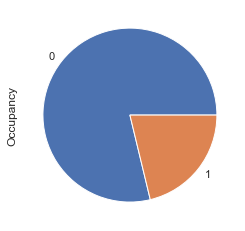

In [83]:
df_train['Occupancy'].value_counts().plot(kind='pie')
df_train['Occupancy'].value_counts()

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           8143 non-null   object 
 1   Temperature    8143 non-null   float64
 2   Humidity       8143 non-null   float64
 3   Light          8143 non-null   float64
 4   CO2            8143 non-null   float64
 5   HumidityRatio  8143 non-null   float64
 6   Occupancy      8143 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 445.4+ KB


As we can see, the dataset contains close to 8143 records and 6 features. The `date` feature doesn't seem to be relevant to detect room occupancy and we want to perform this detection solely based on the sensor values. So, we will drop this feature. We may need to perform further data normalization or transformation, but luckily there is no missing values, and thus no need for data imputation or additional steps to handle missing value. In the next step, we will perform some preliminary data processing and exploration, required for building the model. But I do recommend all of you to perform a detailed EDA, data processing, feature engineering in order to get a well trained model. 

### Data Pre-processing

In [9]:
# Let's create a generic scikit-learn pipeline for training, validation and test data

In [10]:
# Drop un-necessary features
features_to_drop = ['date']
target_variable = 'Occupancy'
y_train = df_train[target_variable]
y_valid = df_valid[target_variable]
y_test = df_test[target_variable]

numeric = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio'] # All features in this dataset is numerical
categorical = [] # No categorical feature in this dataset

In [11]:
def drop_not_wanted_features(df, features_to_drop, target_variable):
    '''
    Function to drop unwanted features
    '''
    for feature in features_to_drop:
        if feature in list(df.columns):
            df.drop(columns=feature, inplace=True)
            
    if target_variable in list(df.columns):
        df.drop(columns=target_variable, inplace=True)
    
    return df

In [12]:
class Droper(BaseEstimator, TransformerMixin):
    '''
    Adding a class for custom pipeline step
    '''
    def __init__(self, features_to_drop, target_variable):
             self.features_to_drop = features_to_drop
             self.target_variable = target_variable
            
    def fit(self, X, y):
             return self
        
    def transform(self, X):
        x = X.copy()
        return drop_not_wanted_features(x, self.features_to_drop, self.target_variable)

In [13]:
# Let's create preprocessing pipelines for both numeric and categorical data.

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [14]:
column_transformer = ColumnTransformer(
    transformers=[
        ('numerical', numeric_transformer, numeric),
        ('categorical', categorical_transformer, categorical)])

### Training the model

In [15]:
# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
# You can further add other custom pipelines
clf = Pipeline(steps=[('droper', Droper(features_to_drop, target_variable)),
                      ('preprocessor', column_transformer),
                      ('classifier', RandomForestClassifier(n_estimators=300,
                                                            random_state=123))])

In [16]:
model = clf.fit(df_train, y_train)

In [18]:
# Accuracy score on validation dataset
model.score(df_valid, y_valid)

0.9770303527481542

In [19]:
# Accuracy score on test dataset
accuracy_score(model.predict(df_test), y_test)

0.951594746716698

In [20]:
# ROC_AUC score on test dataset
roc_auc_score(model.predict(df_test), y_test)

0.9501350997513132

## Model Explainability using DiCE

In [41]:
# Preparing the DiCE data object
data_object = dice_ml.Data(dataframe = df_train[numeric + [target_variable]],
                           continuous_features = numeric,
                           outcome_name = target_variable
                           )

model_object = dice_ml.Model(model = model, backend='sklearn') # Creating Scikit-Learn model object

In [42]:
# Creating DiCE explanation object
explainer = dice_ml.Dice(data_object, model_object, method = 'random')

In [70]:
# Let's select a query instance 
test_query = df_test[400:401][numeric]

cfe = explainer.generate_counterfactuals(test_query, 
                                        total_CFs=4, 
                                        desired_range=None,
                                        desired_class="opposite",
                                        features_to_vary= numeric,
                                        permitted_range = { 'CO2' : [400, 1000]}, # Adding a constraint for CO2 feature
                                        random_seed = 123,
                                        verbose=True)

cfe.visualize_as_dataframe(show_only_changes=True)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.70s/it]

Diverse Counterfactuals found! total time taken: 00 min 01 sec
Query instance (original outcome : 0)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,20.89,23.1,0.0,499.666667,0.003523,0



Diverse Counterfactual set (new outcome: 1.0)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,-,24.000000000000014,763.5,696.3,-,1.0
1,-,24.000000000000014,1083.9,500.0666667000001,-,1.0
2,-,24.000000000000014,1046.8,500.0666667000001,0.005247647,1.0
3,-,24.000000000000014,908.6,500.0666667000001,0.004907888,1.0


In [71]:
# Estimate Local Feature Importance
local_importance = explainer.local_feature_importance(test_query)
print(local_importance.local_importance)

100%|██████████████████████████████████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]

[{'Humidity': 1.0, 'Light': 1.0, 'CO2': 1.0, 'HumidityRatio': 0.4, 'Temperature': 0.2}]


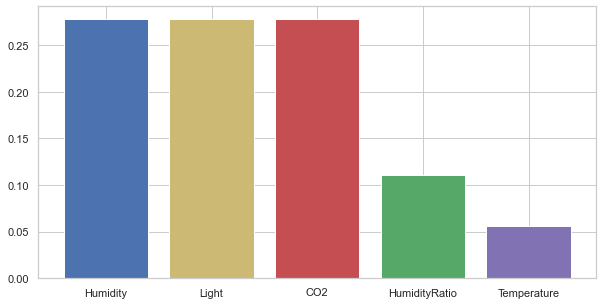

In [72]:
plt.figure(figsize=(10,5))
plt.bar(range(len(local_importance.local_importance[0])), 
        list(local_importance.local_importance[0].values())/(np.sum(list(local_importance.local_importance[0].values()))), 
        tick_label=list(local_importance.local_importance[0].keys()),
        color = list('byrgmc')
       )
plt.show()

Local feature importance showing the humidity and light are more importance features

In [74]:
# Looking for Global Importance
global_importance = explainer.global_feature_importance(df_train[0:1000][numeric], total_CFs=10, posthoc_sparsity_param=None)
print(global_importance.summary_importance)

100%|████████████████████████████████████████████████████████████████████| 1000/1000 [03:27<00:00,  4.81it/s]


{'Light': 0.9704, 'CO2': 0.5017, 'HumidityRatio': 0.114, 'Humidity': 0.0969, 'Temperature': 0.096}


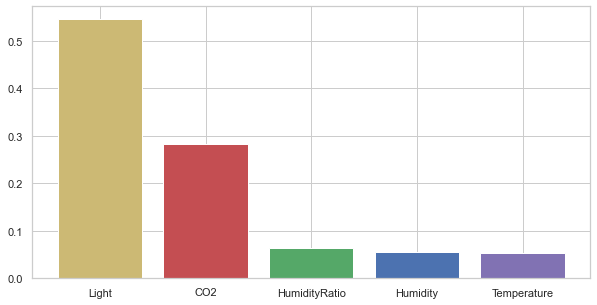

In [77]:
plt.figure(figsize=(10,5))
plt.bar(range(len(global_importance.summary_importance)), 
        list(global_importance.summary_importance.values())/(np.sum(list(global_importance.summary_importance.values()))), 
        tick_label=list(global_importance.summary_importance.keys()),
        color = list('yrgbmc')
       )
plt.show()

Global feature importance showing the Light and CO2 are more importance features considering the subset of data.

## Final Thoughts

Overall, DiCE is a very promising framework for robust CFEs. I recommend you to explore the different algorithms to generate CFEs like KD-Trees, Random Sampling and Genetic algorithms. DiCE examples can sometimes be very random. My recommendation is to always use a random seed to control the random and clearly define the actionable and non-actionable features and set the boundary conditions of the actionable features to generate CFEs which are meaningful and practically feasible. Otherwise, the generated CFEs can be very random and practically not feasible and thus, less impactful to use. 
For other examples of the DiCE framework like using for multi-class classification or regression problems, please explore https://github.com/interpretml/DiCE/tree/master/docs/source/notebooks.  

## Reference

1. Occupancy detection dataset link - https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+
2. DiCE Github project - https://github.com/interpretml/DiCE
3. DiCE Documentation - https://interpretml.github.io/DiCE/
4. Other notebook examples: https://github.com/interpretml/DiCE/tree/master/docs/source/notebooks
5. Some of the utility functions and code are taken from the GitHub Repository of the author - Aditya Bhattacharya https://github.com/adib0073
6. Want to connect with the author of this chapter? You can reach out by any means mentioned here: https://aditya-bhattacharya.net/contact-me/